In [1]:
#Housekeeping
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from glob import glob
import torch as torch
import cv2
from torch import nn
import torch.optim as optim
import random

In [2]:
drunk_path = r"D:\data\drunk\4_drink"
sober_path = r"D:\data\sober"

In [15]:
class AlcoholDataset(Dataset):
    def __init__(self, sober_data, drunk_data):
        self.sober_data = sober_data
        self.drunk_data = drunk_data
        self.images = self.create_dataset()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        return img
    
    def create_dataset(self):
        images = []
        
        with tqdm(total=2300, unit="img") as pbar:
            for root, dirs, files in tqdm(os.walk(sober_path)):
                if files: #If files is not empty
                    for f in files:
                        img = cv2.imread(os.path.join(root, f))
                        if img is not None:
                            img = transforms.ToTensor()(img)
                            images.append((img, 0))
                            pbar.update()
        with tqdm(total=2300, unit="img") as pbar:
            for root, dirs, files in tqdm(os.walk(drunk_path)):
                if files: #If files is not empty
                    for f in files:
                        img = cv2.imread(os.path.join(root, f))
                        if img is not None:
                            img = transforms.ToTensor()(img)
                            images.append((img, 1))
                            pbar.update()
        return images
        
                 
            

In [16]:

# os.walk() generates a 3-tuple for each directory it traverses
count = 0
for root, dirs, files in os.walk(drunk_path):
    if files:
        count += len(files)
print(count)


2300


In [17]:
data = AlcoholDataset(sober_path, drunk_path)

47it [00:10,  4.50it/s]300 [00:10<00:00, 102.49img/s]
 98%|█████████▊| 2250/2300 [00:10<00:00, 215.09img/s]
47it [00:27,  1.69it/s]300 [00:27<00:00, 91.32img/s] 
 98%|█████████▊| 2250/2300 [00:27<00:00, 80.98img/s]


In [18]:
#Train test splits
length_of_dataset = len(data)
num_test = int(length_of_dataset * 0.2)
num_train = length_of_dataset - num_test
print("train_length: ", str(num_train))      
print("test_length: ", str(num_test))

from torch.utils.data import random_split
train_dataset, test_dataset = random_split(data, [num_train, num_test])

train_length:  3600
test_length:  900


In [19]:
#Sanity check
print("Length of train: ", len(train_dataset))
print("Length of test: ", len(test_dataset))

img, label = train_dataset[0]
img, label

Length of train:  3600
Length of test:  900


(tensor([[[0.0157, 0.0118, 0.0039,  ..., 0.5137, 0.4863, 0.4784],
          [0.0157, 0.0157, 0.0039,  ..., 0.5137, 0.4941, 0.4824],
          [0.0157, 0.0157, 0.0118,  ..., 0.5255, 0.5059, 0.4980],
          ...,
          [0.1098, 0.1098, 0.1137,  ..., 0.6667, 0.6431, 0.6275],
          [0.1098, 0.1098, 0.1176,  ..., 0.6667, 0.6431, 0.6314],
          [0.1098, 0.1098, 0.1176,  ..., 0.6667, 0.6431, 0.6314]],
 
         [[0.0157, 0.0118, 0.0039,  ..., 0.5137, 0.4863, 0.4784],
          [0.0157, 0.0157, 0.0039,  ..., 0.5137, 0.4941, 0.4824],
          [0.0157, 0.0157, 0.0118,  ..., 0.5255, 0.5059, 0.4980],
          ...,
          [0.1098, 0.1098, 0.1137,  ..., 0.6667, 0.6431, 0.6275],
          [0.1098, 0.1098, 0.1176,  ..., 0.6667, 0.6431, 0.6314],
          [0.1098, 0.1098, 0.1176,  ..., 0.6667, 0.6431, 0.6314]],
 
         [[0.0157, 0.0118, 0.0039,  ..., 0.5137, 0.4863, 0.4784],
          [0.0157, 0.0157, 0.0039,  ..., 0.5137, 0.4941, 0.4824],
          [0.0157, 0.0157, 0.0118,  ...,

In [21]:
from torch.utils.data import DataLoader
#Turning datasets into dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
val_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True)

In [22]:
#Sanity check
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {batch_size}")

image_batch, label_batch = next(iter(train_dataloader))
print(f"Image batch shape: {image_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Length of train dataloader: 225 batches of 16
Length of val dataloader: 57 batches of 16
Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16])


In [23]:
from util import write_to_csv

In [24]:
def evaluate(epoch, model, test_dataloader, loss_fn, device, batch_size, progress_bar):
        model.eval() #Set model to eval mode
        epoch_loss = 0
        epoch_accuracy = 0
    
        num_batches = len(test_dataloader)
        with tqdm(total=num_test, unit="img") as progress_bar:
            for images, label in test_dataloader:
                
                images = images.to(device=device)
                label = label.to(device=device)

                with torch.autocast(device):
                    pred = model(images) #Make predictions
                    output = torch.sigmoid(pred)
                    #convert probabilities to binary predictions
                    predictions = (output > 0.5).float()
                    pred = pred.squeeze()
                    loss = loss_fn(pred.float(), label.float()) #Crossentropy loss  

                    epoch_loss += loss.item() #Add loss to running loss total

                    correct = (predictions == label).float()
                    accuracy = correct.mean()
                    epoch_accuracy += accuracy.item()
                progress_bar.update(batch_size)
                progress_bar.set_postfix(**{"Loss": loss.item(), 
                                            "Accuracy": accuracy.item()})
        #After processing all batches, average the values to get the average metrics of the epoch
        #print(vec)
        epoch_loss = epoch_loss/num_batches
        epoch_accuracy = epoch_accuracy/num_batches

        #epoch_focal = epoch_focal/num_batches
        #epoch_boundary = epoch_boundary/num_batches
        #Write metrics to CSV file
        metrics = {"Epoch": epoch, 
                    "Loss": epoch_loss, 
                    "Accuracy": epoch_accuracy}
        filename = "eval_metrics_drunk.csv"
        write_to_csv(filename, metrics)
        model.train()
        return epoch_loss
                
      
   





In [25]:
def train(model, epochs, train_dataloader, test_dataloader, scheduler, optimizer, loss_fn, scaler, device):
    for epoch in range(1, epochs+1):
        
        model.train() #Set model to training mode
        epoch_loss = 0
        epoch_accuracy = 0
    
        num_batches = len(train_dataloader)
        with tqdm(total=num_train, desc=f"Epoch {epoch}/{epochs}", unit="img") as progress_bar:
            for images, label in train_dataloader:
                
                images = images.to(device=device)
                label = label.to(device=device)

                with torch.autocast(device):
                    pred = model(images) #Make predictions
                    output = torch.sigmoid(pred)
                    #convert probabilities to binary predictions
                    predictions = (output > 0.5).float()
                    pred = pred.squeeze()
                    #print(pred)
                    #print(label)
                    loss = loss_fn(pred.float(), label.float()) #Crossentropy loss  

                    epoch_loss += loss.item() #Add loss to running loss total

                    correct = (predictions == label).float()
                    accuracy = correct.mean()
                    epoch_accuracy += accuracy.item()
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer) #Unscale so optimizer can correctly apply updates to model params
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clip gradients to prevent exploding gradient
                scaler.step(optimizer)
                scaler.update()

                progress_bar.update(batch_size)
                progress_bar.set_postfix(**{"Loss": loss.item(), 
                                            "Accuracy": accuracy.item()})
        #After processing all batches, average the values to get the average metrics of the epoch
        #print(vec)
        epoch_loss = epoch_loss/num_batches
        epoch_accuracy = epoch_accuracy/num_batches

        #epoch_focal = epoch_focal/num_batches
        #epoch_boundary = epoch_boundary/num_batches
        #Write metrics to CSV file
        metrics = {"Epoch": epoch, 
                    "Loss": epoch_loss, 
                    "Accuracy": epoch_accuracy}
        filename = "training_metrics_drunk.csv"
        write_to_csv(filename, metrics)

        #Write class IOUs to CSV file
        #iou_filename = "training_class_ious_last.csv"
        #write_class_ious(iou_filename, epoch, epoch_class_iou)
       
        #Evaluation round
        model.eval()
        print("Evaluation round")
        with tqdm(total=num_test, desc=f"Epoch {epoch}", unit="img") as progress_bar:
            loss_score = evaluate(epoch, model, test_dataloader, loss_fn, device, batch_size, progress_bar)
        scheduler.step(loss_score)
                
      
   





In [26]:
from model import ResNet50

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 100
learning_rate = 0.001

#model = ResNet(ResidualBlock, [3,4,6,3]).to(device)
model = ResNet50(1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3) #Reduce LR when IOU stops improving for 3 epochs
scaler = torch.cuda.amp.GradScaler(enabled=True)

In [28]:
torch.cuda.empty_cache()
import gc
gc.collect()

6

In [29]:
train(model, epochs, train_dataloader, val_dataloader, scheduler, optimizer, criterion, scaler, device)

Epoch 1/100: 100%|██████████| 3600/3600 [00:45<00:00, 79.98img/s, Accuracy=0.5, Loss=0.301]   


Evaluation round


912img [00:07, 117.93img/s, Accuracy=0.75, Loss=1.73]
Epoch 2/100: 100%|██████████| 3600/3600 [00:47<00:00, 76.10img/s, Accuracy=0.516, Loss=0.261]  


Evaluation round


912img [00:15, 57.99img/s, Accuracy=0.625, Loss=2.04e-5] 
Epoch 3/100: 100%|██████████| 3600/3600 [01:32<00:00, 38.83img/s, Accuracy=0.531, Loss=0.000167]


Evaluation round


912img [00:15, 58.49img/s, Accuracy=0.625, Loss=0.000859]
Epoch 4/100: 100%|██████████| 3600/3600 [02:43<00:00, 22.03img/s, Accuracy=0.5, Loss=0.00261]    


Evaluation round


912img [00:06, 143.22img/s, Accuracy=0.5, Loss=0.00173]
Epoch 5/100: 100%|██████████| 3600/3600 [01:12<00:00, 49.85img/s, Accuracy=0.531, Loss=6.36e-6] 


Evaluation round


912img [00:11, 78.20img/s, Accuracy=0.625, Loss=6.9e-5] 
Epoch 6/100: 100%|██████████| 3600/3600 [01:26<00:00, 41.61img/s, Accuracy=0.5, Loss=0.0579]    


Evaluation round


912img [00:13, 70.07img/s, Accuracy=0.5, Loss=5.07e-7]
Epoch 7/100: 100%|██████████| 3600/3600 [01:24<00:00, 42.80img/s, Accuracy=0.531, Loss=3.08e-5] 


Evaluation round


912img [00:13, 65.54img/s, Accuracy=1, Loss=0.00291] 
Epoch 8/100: 100%|██████████| 3600/3600 [01:49<00:00, 32.78img/s, Accuracy=0.531, Loss=2.16e-5] 


Evaluation round


912img [00:17, 51.22img/s, Accuracy=0.625, Loss=0.000162]
Epoch 9/100: 100%|██████████| 3600/3600 [02:42<00:00, 22.21img/s, Accuracy=0.5, Loss=0.000729]  


Evaluation round


912img [00:25, 36.20img/s, Accuracy=0.625, Loss=0.00151]
Epoch 10/100: 100%|██████████| 3600/3600 [02:38<00:00, 22.70img/s, Accuracy=0.531, Loss=5.87e-5] 


Evaluation round


912img [00:27, 33.00img/s, Accuracy=0.625, Loss=8.05e-7]
Epoch 11/100:   6%|▌         | 208/3600 [00:09<02:37, 21.57img/s, Accuracy=0.625, Loss=0.000639]


KeyboardInterrupt: 

In [30]:
#save model
state_dict = model.state_dict()
torch.save(state_dict, "model_drunk.pth")

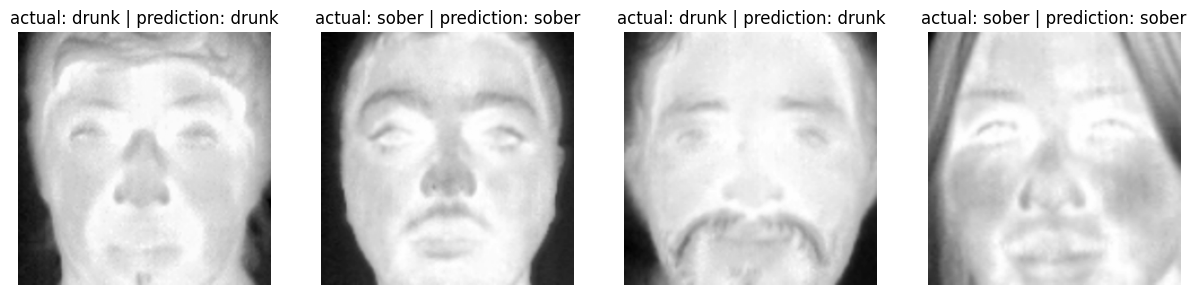

In [42]:
#take random 3 imgs for prediction example
img, label = next(iter(val_dataloader))
model.eval()
random_indices= random.sample(range(8), 4)
imgs = []
labels = []

for idx in random_indices:
  imgs.append(img[idx])
  if label[idx].item() == 0:
    labels.append("sober")
  else:
    labels.append("drunk")

fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 3 columns

# Iterate through each subplot and plot the image
prediction = ""
for i, ax in enumerate(axes):

    #model prediction
    img = imgs[i]
    img = img.unsqueeze(dim=0)
    img = img.to(device)

    pred = model(img)

    output = torch.sigmoid(pred)

    if output >= 0.5:
        prediction = "drunk"
    else:
        prediction = "sober"
    img_transposed = np.transpose(imgs[i], (1, 2, 0))
    ax.imshow(img_transposed)  # Plot the image on the subplot
    ax.set_title(f"actual: {labels[i]} | prediction: {prediction}") 
    ax.axis("off")

In [39]:
from util import plot_metrics

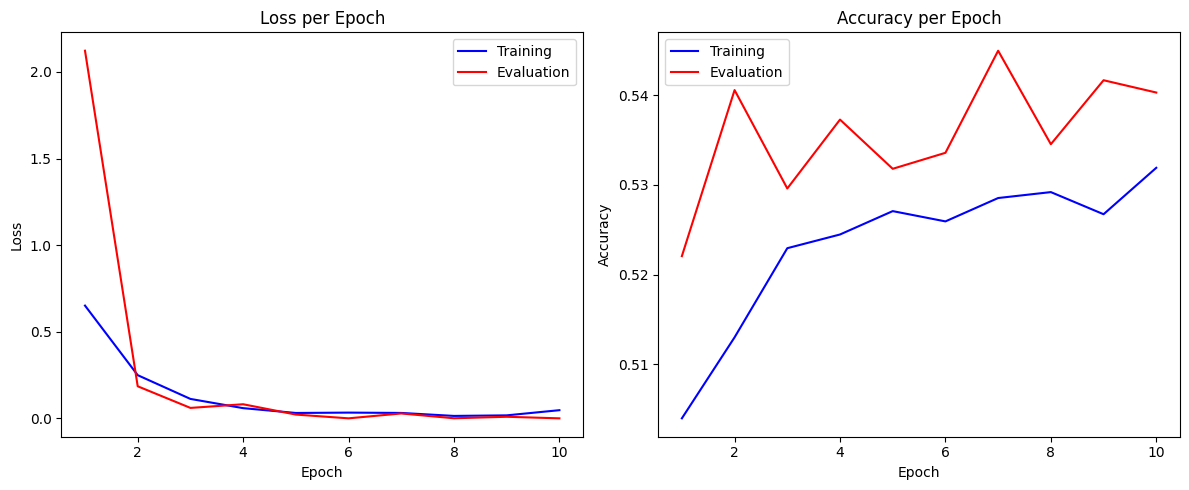

In [40]:
#plot metrics
train_csv = "training_metrics_drunk.csv"
eval_csv = "eval_metrics_drunk.csv"
plot_metrics(train_csv, eval_csv)